<a href="https://colab.research.google.com/github/ameralhomdy/DS-Unit-2-Kaggle-Challenge/blob/master/module1/assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

     |████████████████████████████████| 102kB 2.7MB/s 


In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv', na_values=(0, '0')), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv',na_values=(0, '0')))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv', na_values=(0, '0'))
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
# import block

pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
import category_encoders as ce 

In [29]:
# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [0]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    
    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [35]:
train.isnull().sum()

id                           1
amount_tsh               33265
date_recorded                0
funder                    3511
gps_height               16305
installer                 3524
longitude                 1442
latitude                  1442
wpt_name                     0
num_private              46932
basin                        0
subvillage                 286
region                       0
region_code                  0
district_code               19
lga                          0
ward                         0
population               17066
public_meeting            2644
recorded_by                  0
scheme_management         3128
scheme_name              22532
permit                    2443
construction_year        16517
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [32]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
43360,72938.0,NaN,2011-07-27,NaN,NaN,NaN,33.542898,-9.174777,Kwa Mzee Noa,NaN,Lake Nyasa,Mpandapanda,Mbeya,12,4.0,Rungwe,Kiwira,NaN,True,GeoData Consultants Ltd,VWC,K,NaN,NaN,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
7263,65358.0,500.0,2011-03-23,Rc Church,2049.0,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,NaN,Rufiji,Kitichi,Iringa,11,4.0,Njombe,Imalinyi,175.0,True,GeoData Consultants Ltd,WUA,Tove Mtwango gravity Scheme,True,2008.0,gravity,gravity,gravity,wua,user-group,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
2486,469.0,25.0,2011-03-07,Donor,290.0,Do,38.238568,-6.179919,Kwasungwini,NaN,Wami / Ruvu,Kwedigongo,Pwani,6,1.0,Bagamoyo,Mbwewe,2300.0,True,GeoData Consultants Ltd,VWC,NaN,False,2010.0,india mark ii,india mark ii,handpump,vwc,user-group,pay per bucket,per bucket,salty,salty,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
313,1298.0,NaN,2011-07-31,Government Of Tanzania,NaN,DWE,30.716727,-1.289055,Kwajovin 2,NaN,Lake Victoria,Kihanga,Kagera,18,1.0,Karagwe,Isingiro,NaN,True,GeoData Consultants Ltd,NaN,NaN,True,NaN,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other,non functional
52726,27001.0,NaN,2011-03-10,Water,NaN,Gove,35.389331,-6.399942,Chama,NaN,Internal,Mtakuj,Dodoma,1,6.0,Bahi,Nondwa,NaN,True,GeoData Consultants Ltd,VWC,Zeje,True,NaN,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional


In [0]:
# Add feature - pump age
train['pump_age'] = 2011 - train['construction_year']
val['pump_age'] = 2011 - val['construction_year']
test['pump_age'] = 2011 - test['construction_year']

In [0]:
target = 'status_group'
train_features = train.drop(columns=[target, 'id'])

numeric_features = train_features.select_dtypes(include='number').columns.tolist()

cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()
duplicates = ['extraction_type_group', 'extraction_type_class', 'district_code', 'management_group', 'payment_type',  'quality_group', 'source_type', 'source_class', 'waterpoint_type_group']

features = numeric_features + categorical_features

# Arrange data into X features matrix and y target vector 
X_train = train[features].drop(columns=duplicates)
y_train = train[target]
X_val = val[features].drop(columns=duplicates)
y_val = val[target]
X_test = test[features].drop(columns=duplicates)

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(min_samples_leaf=10, random_state=42)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on train, val
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on test
y_pred = pipeline.predict(X_test)

Train Accuracy 0.8355429292929293
Validation Accuracy 0.775


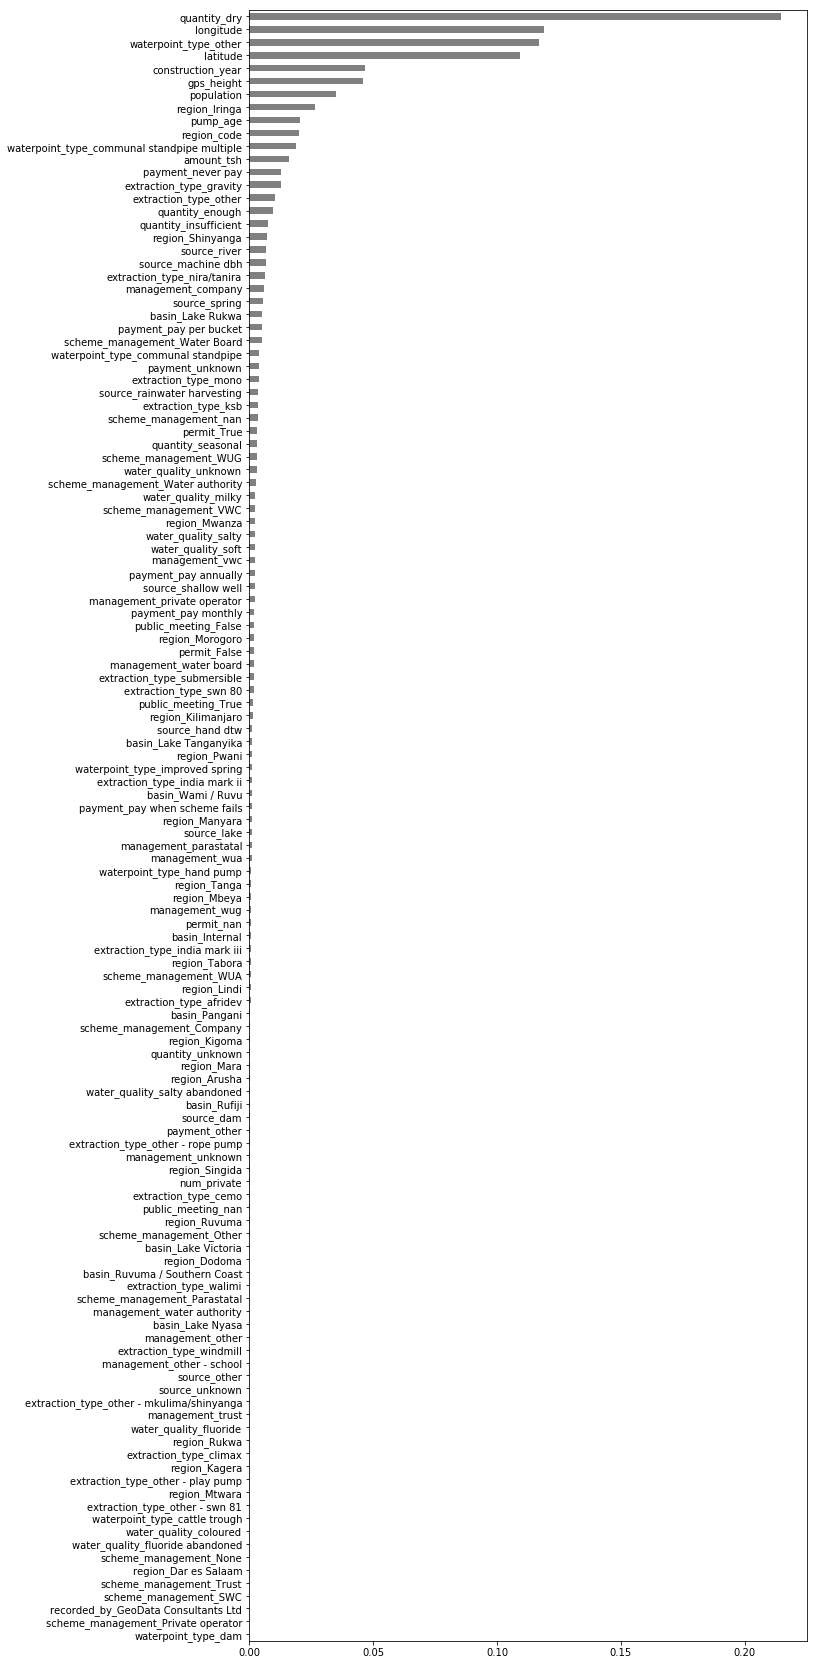

In [61]:
model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

In [0]:

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_val_encoded = encoder.transform(X_val)

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded, y_train)
X_val_imputed = imputer.transform(X_val_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [0]:
# Mapping the ys to integers for the encoder
mapdict = {
    'functional': 3,
    'non functional': 1,
    'functional needs repair': 2
}
y_train_num = y_train.map(mapdict)
y_val_num = y_val.map(mapdict)

In [107]:
# Selecting best features

selector = SelectKBest(score_func=f_regression, k = 25)
X_train_selected = selector.fit_transform(X_train_scaled, y_train_num)
X_val_selected = selector.transform(X_val_scaled)

X_train_selected.shape, X_val_selected.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


((47520, 25), (11880, 25))

In [108]:
# fitting into model

model = DecisionTreeClassifier(min_samples_leaf=10, random_state=42)
model.fit(X_train_selected, y_train)
print('Validation Accuracy', model.score(X_val_selected, y_val))

Validation Accuracy 0.7616161616161616


####Since my first model had a better score I will use that to submit to kaggle

In [109]:
y_pred = pipeline.predict(X_test)
y_pred

array(['functional', 'non functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [0]:
# Formatting submission
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-Amer3.csv', index = False)